In [7]:
# importa biblioteca pandas
import pandas as pd
# importa biblioteca numpy
import numpy as np
# importa biblioteca statsmodels
import statsmodels.api as sm

! pip install stepwise_regression
# local do arquivo
Caminho='C:/_Academico/PUC/202401/PROJETO INTEGRADO NEGÓCIOS/Credito.xlsx'


In [18]:
 #Traz o arquivo para o Python
df=pd.read_excel(Caminho)
df.head()

,tipo,est_civ,qtd_com,tempo_em,sal_cli,qtd_parc,vlr_cpr,vlr_prt,tipo_cre,idade,est_civ_2,est_civ_3,est_civ_4,est_civ_5
0,1,1,1,31,0.01,4,1200,408.45,1,59,0,0,0,0
1,1,1,1,34,0.01,6,600,159.97,1,61,0,0,0,0
2,1,5,1,74,1.00,12,5000,555.55,0,42,0,0,0,1
3,1,1,0,332,0.10,12,500,90.66,1,50,0,0,0,0
4,1,2,0,74,1.00,12,3700,403.19,0,32,1,0,0,0


In [15]:
#Cria variável Dummy

dummy_est_civ = pd.get_dummies(df['est_civ'], prefix='est_civ', drop_first=True)
dummy_est_civ = dummy_est_civ.astype(int)
print(dummy_est_civ)


       est_civ_2  est_civ_3  est_civ_4  est_civ_5
0              0          0          0          0
1              0          0          0          0
2              0          0          0          1
3              0          0          0          0
4              1          0          0          0
...          ...        ...        ...        ...
11995          1          0          0          0
11996          0          1          0          0
11997          1          0          0          0
11998          0          0          0          0
11999          0          1          0          0

[12000 rows x 4 columns]


In [16]:
# Concatenando as variáveis dummy com o DataFrame original
df = pd.concat([df, dummy_est_civ], axis=1)

In [17]:

def stepwise_logistic_regression(X, y, 
                                 initial_list=[], 
                                 threshold_in=0.01, 
                                 threshold_out=0.05, 
                                 verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Adicionando variável: {} com p-value {:.6}'.format(best_feature, best_pval))

        # Backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Removendo variável: {} com p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

X = df.drop(columns=['tipo', 'est_civ'])  # Variáveis preditoras - tira tipo que é a resposta e est_civ que virou dummy
y = df['tipo']  # Variável resposta

selected_features = stepwise_logistic_regression(X, y)

print('Variáveis selecionadas:')
print(selected_features)

Adicionando variável: qtd_parc com p-value 7.87937e-183
Adicionando variável: tipo_cre com p-value 5.80701e-108
Adicionando variável: qtd_com com p-value 3.32786e-84
Adicionando variável: idade com p-value 1.40623e-59
Adicionando variável: tempo_em com p-value 1.70589e-07
Adicionando variável: vlr_prt com p-value 0.000106013
Adicionando variável: sal_cli com p-value 4.56617e-05
Variáveis selecionadas:
['qtd_parc', 'tipo_cre', 'qtd_com', 'idade', 'tempo_em', 'vlr_prt', 'sal_cli']


In [19]:
#Modelo de Regressão Logística pós Stepwise - somente as variáveis listadas acima
from statsmodels.formula.api import logit
modelo=logit('tipo ~ qtd_parc+tipo_cre+qtd_com+idade+tempo_em+vlr_prt+sal_cli', data=df).fit()

Optimization terminated successfully.
         Current function value: 0.603578
         Iterations 6


In [20]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   tipo   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11992
Method:                           MLE   Df Model:                            7
Date:                Mon, 24 Mar 2025   Pseudo R-squ.:                  0.1292
Time:                        11:14:03   Log-Likelihood:                -7242.9
converged:                       True   LL-Null:                       -8317.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5152      0.097     -5.308      0.000      -0.705      -0.325
qtd_parc      -0.2304      0.007    -32.893      0.000      -0.244      -0.217
tipo_cre       1.2320      0.061     20.161      0.000       1.112       1.352
qtd_com        0.7033      0.041     17.134      0.000       0.623       0.784
idade          0.0211      0.002     12.472      0.000       0.018       0.024
tempo_em       0.0013      0.000      5.244      0.000       0.001       0.002
vlr_prt       -0.0010      0.000     -5.684      0.000      -0.001      -0.001
sal_cli     8.871e-05   2.18e-05      4.077      0.000    4.61e-05       0.000
==============================================================================
"""

In [21]:
#Importa ferramentas para análise do modelo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve


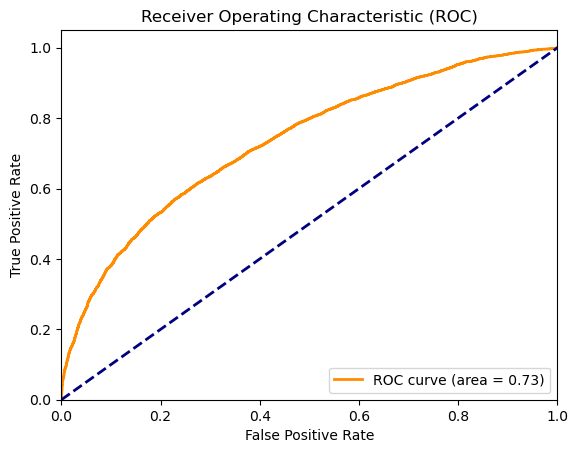

In [22]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.tools import add_constant

# Adicione uma constante ao DataFrame X
X_constant = add_constant(X[selected_features])

# Calcula as probabilidades previstas
y_pred_prob = modelo.predict(X_constant)

# Calcula o FPR (Taxa de Falsos Positivos) e TPR (Taxa de Verdadeiros Positivos)
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Calcula a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Curva ROC
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [23]:
from scipy.stats import chi2

# Calcula a estatística do teste de Hosmer-Lemeshow
hosmer_lemeshow_statistic = np.sum((y_pred_prob - y_pred_prob.mean())**2)

# Define o número de grupos (bins) para o teste de Hosmer-Lemeshow
num_groups = 10

# Calcula os graus de liberdade
df = num_groups - 2

# Calcula o valor-p comparando a estatística do teste com a distribuição qui-quadrado
p_value = 1 - chi2.cdf(hosmer_lemeshow_statistic, df)

# Exibe o valor-p com três casas decimais
print("Valor-p do teste de Hosmer-Lemeshow: {:.3f}".format(p_value))

Valor-p do teste de Hosmer-Lemeshow: 0.000


In [24]:
# Matriz de Confusão
y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[4078 1922]
 [2074 3926]]


In [25]:
# Calcula a matriz de confusão
conf_matrix = confusion_matrix(y, y_pred)

# Calcula o total de observações
total_observations = np.sum(conf_matrix)

# Calcula o total de acertos (soma da diagonal principal)
total_acertos = np.trace(conf_matrix)

# Calcula o total de erros (subtrai o total de acertos do total de observações)
total_erros = total_observations - total_acertos

# Calcula a porcentagem de acertos e erros
percent_acertos = (total_acertos / total_observations) * 100
percent_erros = (total_erros / total_observations) * 100

# Exibe os resultados
print("Total de acertos:", total_acertos)
print("Total de erros:", total_erros)
print("Porcentagem de acertos: {:.2f}%".format(percent_acertos))
print("Porcentagem de erros: {:.2f}%".format(percent_erros))

Total de acertos: 8004
Total de erros: 3996
Porcentagem de acertos: 66.70%
Porcentagem de erros: 33.30%


In [26]:
# Calcula a estatística de Cox e Snell
llf_null = -modelo.llnull
llf_modelo = modelo.llf
n = len(y)
cox_snell_statistic = 1 - np.exp((2/n) * (llf_null - llf_modelo))

# Exibe a estatística de Cox e Snell
print("Estatística de Cox e Snell:", cox_snell_statistic)

Estatística de Cox e Snell: -12.375831179045122


In [27]:
# Calcula a função de verossimilhança do modelo nulo (sem preditores)
llf_null = modelo.llnull

# Calcula a função de verossimilhança do modelo ajustado
llf_modelo = modelo.llf

# Calcula o número total de observações
n = len(y)

# Calcula a estatística de Nagelkerke
R2_nagelkerke = 1 - (np.exp(-2 * (llf_null - llf_modelo) / n) / (1 - np.exp(llf_modelo * 2 / n)))

# Exibe a estatística de Nagelkerke
print("Estatística de Nagelkerke:", R2_nagelkerke)

Estatística de Nagelkerke: -0.7065153685531163
